# Affine Network with compliant Crosslinkers - Angular Integration

- Notebook for efficient UMAT analysis at the GP scale
- Includes fortran subroutines for random generation of material parameters

In [1]:
! /bin/python3.6 -m numpy.f2py -c -m umatpy py_anl_ai_mcs.f90 umat_anl_ai_mcs.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "umatpy" sources
f2py options: []
f2py:> /tmp/tmpmz2n0pch/src.linux-x86_64-3.6/umatpymodule.c
creating /tmp/tmpmz2n0pch/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'py_anl_ai_mcs.f90' (format:free)
{'before': '', 'this': 'use', 'after': ',intrinsic :: iso_fortran_env '}
Line #3 in py_anl_ai_mcs.f90:"use,intrinsic :: ISO_Fortran_env "
	analyzeline: Could not crack the use statement.
	Reading file 'aba_param.inc' (format:fix)
Line #15 in py_anl_ai_mcs.f90:"PARAMETER(NTENS = 6, NSTATEV = NSDV, NSHR=3) "
	determineexprtype: could not determine expressions ('nsdv') type.
analyzeline: Failed to evaluate 'nsdv'. Ignoring: name 'nsdv' is not defined
	Reading file 'umat_anl_ai_mcs.f90' (format:free)
Line #22 in umat_a

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

import umatpy

In [3]:
base_dir = '/home/lpacheco/biopolymer-networks/3_affnet_cl_ai_mcs'
os.chdir(base_dir)

In [4]:
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [5]:
''' MATERIAL PROPERTIES '''

##### Penalty parameter (0) #####
K = 1000000000000.0 # 1000.0
##### Isotropic matrix (1-3) #####
C10 = 0.0 # 0.0
C01 = 0.0 # 0.0
PHI = 1.0 # Filament volume fraction 1.0
###### Single Filament (4-11) #####
L = 1.96 # Filament contour length [microm] 1.96
R0F = 1.63 # Filament initial end-to-end distance [microm] 1.63
R0C = 0.014 # CL initial end-to-end distance [microm] 0.014
ETA = 0.6666 # CL stiffness [0,1] 0.6666
MU0 = 11111111111111111111111138600.0 # Stretch modulus [pN] inf
BETA = 0.5 # 0.5
B0 = 294.0*16.0*1.38065e-5 # Bending stiffness (T*Lp*kb) [pN * microm**2] 294.0*16.0*1.38e-5
LAMBDA0 = 1.00 # Pre-stretch 1.00
##### Affine Network (12-13) #####
n = 7.66 # Isotropic filaments per unit volume [microm**-3] 7.66
B = 0.001 # Dispersion parameter 0.001

base_material_properties = [K,
    C10, C01, PHI,
    L, R0F, R0C, ETA, MU0, BETA, B0, LAMBDA0,
    n, B
]

mat_props_tex = ['$K$', '$C_{10}$', '$C_{01}$', '$\phi$', 
                 '$L$', '$r_{0,f}$', '$r_{0,c}$', '$\eta$', '$\mu_0$', '$\beta$', '$B_0$', '$\lambda_0$', 
                 '$n$', '$b$']

# Write material properties to a file
'''with open('material_properties.txt', 'w') as f:
    for prop in material_properties:
        f.write(f'{prop}\n')'''

"with open('material_properties.txt', 'w') as f:\n    for prop in material_properties:\n        f.write(f'{prop}\n')"

## Auxiliary Functions

In [6]:
''' AUX FUNCTIONS '''

# Setting the deformation gradient
def dfgrd(def_mode:str, stretch:float):
    """
    Computes the deformation gradient F for simple deformation modes.

    INPUTS: 
        def_mode: str - Deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions)
        stretch(/shear): float
    OUTPUTS: 
        F: ndarray - Deformation gradient (3x3)
    """
    if def_mode not in ['U', 'SSx', 'SSy']:
        raise ValueError("Invalid deformation mode. Choose 'U', 'SSx', or 'SSy'.")
    
    if not isinstance(stretch, (int, float)):
        raise TypeError("Stretch/shear value must be a number.")

    F = np.eye(3)
    
    if def_mode == 'U':
        F[0,0] = stretch
        F[1,1] = 1/np.sqrt(stretch)
        F[2,2] = 1/np.sqrt(stretch)
    elif def_mode == 'SSx':
        F[0,1] = stretch
    elif def_mode == 'SSy':
        F[1,0] = stretch
    return F

# Function for sensitivity analysis
def sens_analysis(def_mode:str,
                  stretch: list, 
                  time: list, 
                  mat_props: list, id_props:list, range_props:dict, 
                  id_stress:int):
    ''' Performs a sensitivity analysis on the chosen parameters for the compliant CL actin network (material point).

    INPUTS: def_mode - deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions);
            stretch - [stretch_min, stretch_max, nsteps];
            time - [time_0, time_end, dtime];
            mat_props - list with the baseline material properties;
            id_props - indices of the material properties being studies in the array mat_props [i,j,k, ...];
            range_props - dict{'min':[imin, jmin, kmin...], 'max':[imax, jmax, kmax...], 'nstep':[int, int, int, ...]};
            id_stress - index of the target stress component [xx yy zz xy xz yz];

    OUTPUTS: stress - stress array as a function of given stretch values (i_n, j_n, k_n..., nsteps);
             map_props - array that maps each stress vector to the corresponding material properties being studied (i_n, j_n, k_n..., len(id_props))'''
    # List with all values for each property being studied
    sens_props, len_props, stress_flat = [], [], []
    stretch_arr = np.arange(stretch[0], stretch[1], (stretch[1]-stretch[0])/stretch[2])
    for i, _ in enumerate(id_props):
        aux_min = range_props['min'][i]
        aux_max = range_props['max'][i]
        aux_inc = range_props['nstep'][i]
        aux_list = np.linspace(aux_min, aux_max, aux_inc).tolist()
        len_props.append(len(aux_list))
        sens_props.append(aux_list)
    len_props.append(len(id_props))
    comb_props_flat = list(product(*sens_props))
    for i, comb in enumerate(comb_props_flat):
        kstep = 0
        aux_time, dtime = [time[0:2], time[2]]
        aux_stress = []
        for j, id in enumerate(id_props):
            mat_props[id] = comb[j]
        for k, stretch in enumerate(stretch_arr):
            kstep += k
            F = dfgrd(def_mode, stretch)
            stress = umatpy.run_umat_py(mat_props, F, aux_time, dtime, kstep)
            aux_time[0] += dtime
            aux_stress.append(stress[id_stress])
        stress_flat.append(aux_stress)
    map_props = np.array(comb_props_flat).reshape(len_props)
    aux_shape = len_props[:-1]
    aux_shape.append(len(stretch_arr))
    stress_curves = np.array(stress_flat).reshape(aux_shape)
    return map_props, stress_curves


## Stress-Stretch curves

### Null deformation

(-0.1, 1.0)

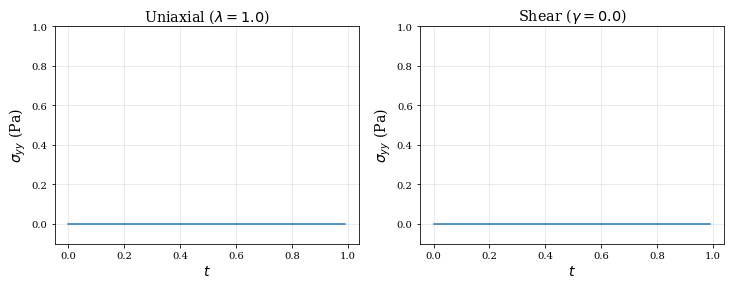

In [7]:
'UNIAXIAL and SHEAR'

material_properties = base_material_properties.copy()

stretch_initial = 1.0
stretch_max = 1.0
nsteps = 100
# dstretch = (stretch_max-stretch_initial)/nsteps
time_list = [0, 0]
time_initial = 0.0
time_max = 1.0
kstep=1
dtime = (time_max-time_initial)/nsteps
time_array = np.arange(time_initial, time_max, dtime)
stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))

kstep=1
stretch = 1.0
shear = 0.0
for j, t in enumerate(time_array):
    F_uni = dfgrd('U', stretch)
    F_sh = dfgrd('SSx', shear)
    stress_uni = umatpy.run_umat_py(material_properties, F_uni, [t, t+dtime], dtime, kstep)
    stress_array_uni[0,j] = stress_uni[0]
    stress_sh = umatpy.run_umat_py(material_properties, F_sh, [t, t+dtime], dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1] - stress_sh[2]
    # time[0] += dtime
    kstep += 1

fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(time_array, stress_array_uni[0, :])
axs[0].set_title('Uniaxial ($\\lambda = 1.0$)')
axs[0].set_xlabel('$t$', fontsize=14)
axs[0].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[0].grid(alpha=0.3)
axs[0].set_ylim((-0.1, 1))

axs[1].plot(time_array, stress_array_sh[0, :])
axs[1].set_title('Shear ($\\gamma = 0.0$)')
axs[1].set_xlabel('$t$', fontsize=14)
axs[1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1].grid(alpha=0.3)
axs[1].set_ylim((-0.1, 1))

### Ramp deformation

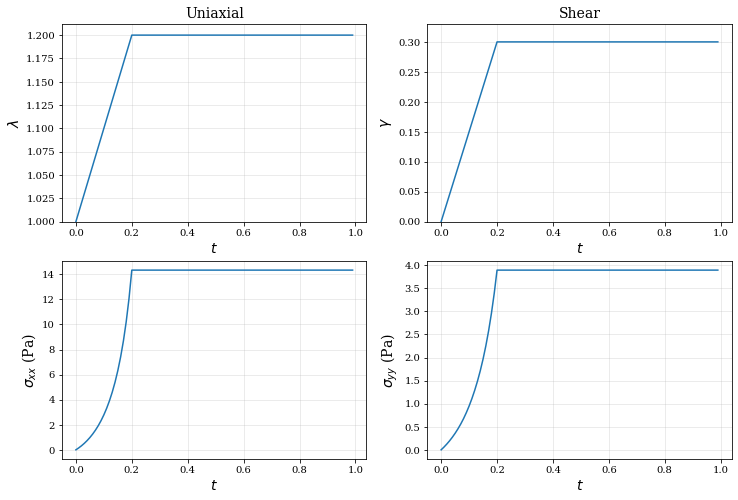

In [8]:
'UNIAXIAL and SHEAR'
stretch_list, shear_list = [], []
material_properties = base_material_properties.copy()

def ramp(time, ramp_time, min_def, max_def):
    # Initial time is zero!
    if time >= ramp_time:
        deformation = max_def
    if time < ramp_time:
        deformation = (max_def-min_def)/ramp_time * time + min_def
    return deformation 

stretch_initial = 1.0
stretch_max = 1.2
shear_initial = 0.0
shear_max = 0.3

nsteps = 100

time_list = [0, 0]
time_initial = 0.0
time_max = 1.0
ramp_time = 0.2
kstep=1
dtime = (time_max-time_initial)/nsteps

time_array = np.arange(time_initial, time_max, dtime)
stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))

kstep=1
for j, t in enumerate(time_array):
    stretch = ramp(t, ramp_time, stretch_initial, stretch_max)
    shear = ramp(t, ramp_time, shear_initial, shear_max)
    stretch_list.append(stretch)
    shear_list.append(shear)
    F_uni = dfgrd('U', stretch)
    F_sh = dfgrd('SSx', shear)
    stress_uni = umatpy.run_umat_py(material_properties, F_uni, [t, t+dtime], dtime, kstep)
    stress_array_uni[0,j] = stress_uni[0]
    stress_sh = umatpy.run_umat_py(material_properties, F_sh, [t, t+dtime], dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1]-stress_sh[2]
    # time[0] += dtime
    kstep += 1

fig, axs = plt.subplots(2,2, figsize = (12,8))
axs[0,0].plot(time_array, stretch_list)
axs[0,0].set_xlabel('$t$', fontsize=14)
axs[0,0].set_ylabel('$\lambda$', fontsize=14)
axs[0,0].set_title('Uniaxial', fontsize=14)
axs[0,0].grid(alpha=0.3)
axs[0,0].set_ylim((1.,stretch_max*1.01))
axs[1,0].plot(time_array, stress_array_uni[0, :])
axs[1,0].set_xlabel('$t$', fontsize=14)
axs[1,0].set_ylabel('$\\sigma_{xx}$ (Pa)', fontsize=14)
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(time_array, shear_list)
axs[0,1].set_xlabel('$t$', fontsize=14)
axs[0,1].set_ylabel('$\gamma$', fontsize=14)
axs[0,1].set_title('Shear', fontsize=14)
axs[0,1].grid(alpha=0.3)
axs[0,1].set_ylim((0,shear_max*1.1))
axs[1,1].plot(time_array, stress_array_sh[0, :])
axs[1,1].set_xlabel('$t$', fontsize=14)
axs[1,1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1,1].grid(alpha=0.3)

# plt.savefig('1_02_08.pdf')


In [9]:
stress_array_uni[0, -20:], stress_array_sh[0, -20:]

(array([14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026]),
 array([3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659]))

### Linear deformation

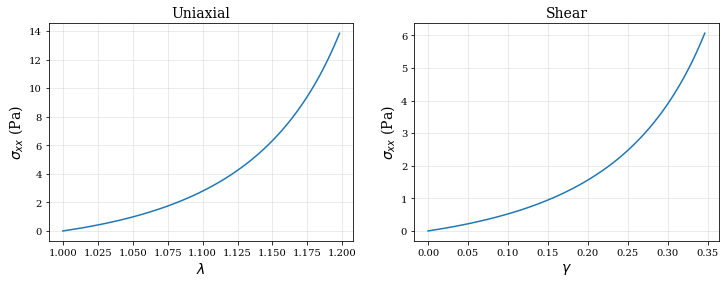

In [10]:
'UNIAXIAL and SHEAR'
stretch_list, shear_list = [], []
material_properties = base_material_properties.copy()

stretch_initial = 1.0
stretch_max = 1.2
shear_initial = 0.0
shear_max = 0.35
nsteps = 100
dstretch = (stretch_max-stretch_initial)/nsteps
dshear = (shear_max-shear_initial)/nsteps

stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))
stretch_array = np.arange(stretch_initial, stretch_max, dstretch)
shear_array = np.arange(shear_initial, shear_max, dshear)

time = [0, 0]
dtime=0.1
kstep=1
for i, stretch in enumerate(stretch_array):
    F = dfgrd('U', stretch)
    stress_uni = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_array_uni[0,i] = stress_uni[0]
    time[0] += dtime
    kstep += 1

time = [0, 0]
kstep=1
for j, shear in enumerate(shear_array):
    F = dfgrd('SSx', shear)
    stress_sh = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1] - stress_sh[2]
    time[0] += dtime
    kstep += 1


fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(stretch_array, stress_array_uni[0,:])
axs[0].set_xlabel('$\lambda$', fontsize=14)
axs[0].set_ylabel('$\\sigma_{xx}$ (Pa)', fontsize=14)
axs[0].set_title('Uniaxial', fontsize=14)
axs[0].grid(alpha=0.3)
axs[1].plot(shear_array, stress_array_sh[0, :])
axs[1].set_xlabel('$\gamma$', fontsize=14)
axs[1].set_ylabel('$\\sigma_{xx}$ (Pa)', fontsize=14)
axs[1].set_title('Shear', fontsize=14)
axs[1].grid(alpha=0.3)


## Sensitivity analysis

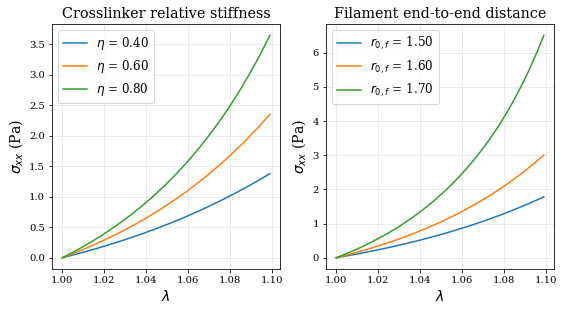

In [11]:
# Test if the sensitivity analysis function is working properly
material_properties = base_material_properties.copy()
'''range_dict = {'min':[1.96, 1.4, 0.01],
              'max':[2.16, 1.6, 0.014],
              'nstep':[3, 3, 3]}'''

# 1st plot data
range_dict = {'min':[0.4],
              'max':[0.8],
              'nstep':[3]}
map_array, curves = sens_analysis(def_mode='U', stretch=[1.0, 1.1, 100], time=[0,0,0.1], mat_props=material_properties, id_props=[7], range_props=range_dict, id_stress=0)
# print(map_array.shape, curves.shape)

# 2nd plot data
range_dict2 = {'min':[1.5],
              'max':[1.7],
              'nstep':[3]}
map_array2, curves2 = sens_analysis(def_mode='U', stretch=[1.0, 1.1, 100], time=[0,0,0.1], mat_props=material_properties, id_props=[5], range_props=range_dict2, id_stress=0)

# Sensitity analysis plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4.5))
for i in range(3):
    ax1.plot(np.arange(1.0, 1.1, (1.1-1.0)/100), curves[i,:], label=mat_props_tex[7] + f' = {map_array[i].item():.2f}')
    ax2.plot(np.arange(1.0, 1.1, (1.1-1.0)/100), curves2[i,:], label=mat_props_tex[5] + f' = {map_array2[i].item():.2f}')

ax1.set_xlabel('$\lambda$', fontsize=14)
ax1.set_ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)
ax1.set_title('Crosslinker relative stiffness')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

ax2.set_xlabel('$\lambda$', fontsize=14)
ax2.set_ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)
ax2.set_title('Filament end-to-end distance')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12)

# fig.savefig('00plot.png', bbox_inches='tight')

In [12]:
# Sensitivity analysis - Studying more than 1 parameter
material_properties = base_material_properties.copy()
stretch_aux_list = [1.0, 1.1, 100]
range_dict = {'min':[1.96, 1.4, 0.01],
              'max':[2.1, 1.6, 0.014],
              'nstep':[3, 3, 3]}

map_array, curves = sens_analysis(def_mode='U', stretch = stretch_aux_list, time=[0,0,0.1], mat_props=material_properties, id_props=[4,5,6], range_props=range_dict, id_stress=0)

Text(0, 0.5, '$\\sigma_{xx}$ (Pa)')

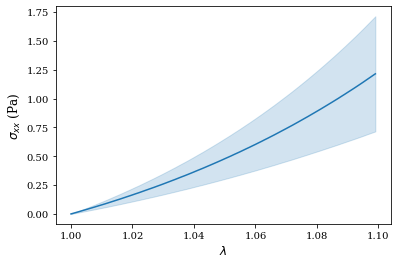

In [13]:
curves_for_df = curves.reshape(-1,100)
curve_id = np.arange(curves_for_df.shape[0])
stretches = np.tile(np.arange(stretch_aux_list[0], stretch_aux_list[1], (stretch_aux_list[1]-stretch_aux_list[0])/stretch_aux_list[2]), curves_for_df.shape[0])

df = pd.DataFrame({
    'curve_id': np.repeat(curve_id, 100),
    'stretch': stretches, 
    'stress': curves_for_df.flatten()
    })

plt.figure(figsize=(6,4))
sns.lineplot(x='stretch', y='stress', data=df, ci='sd')
plt.xlabel('$\lambda$')
plt.ylabel('$\sigma_{xx}$ (Pa)')

## Model Validation

Comparison with results from "An affine continuum mechanical model for cross-linked F-actin networks with compliant linker proteins" (Holzapfel, Unterberger and Ogden, 2014) and results obtained using a single unit cube element in Abaqus.

In [14]:
# Get abaqus results
'''os.chdir('test_in_abaqus')
abq_sh_033 = np.load('output_sh_033.npy')
abq_sh_067 = np.load('output_sh_067.npy')
abq_sh_100 = np.load('output_sh_100.npy')
abq_list = [abq_sh_100, abq_sh_067, abq_sh_033]
os.chdir('..')'''

"os.chdir('test_in_abaqus')\nabq_sh_033 = np.load('output_sh_033.npy')\nabq_sh_067 = np.load('output_sh_067.npy')\nabq_sh_100 = np.load('output_sh_100.npy')\nabq_list = [abq_sh_100, abq_sh_067, abq_sh_033]\nos.chdir('..')"

In [15]:
'''##### Normal stress vs Shear deformation (Figure 6a) #####
material_properties = base_material_properties.copy()

# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 100
dshear = (shear_max-shear_initial)/nsteps
# shear_array = np.arange(shear_initial, shear_max, dshear)
shear_array = np.linspace(shear_initial, shear_max, nsteps)
dtime = 0.01
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))
interp_list, r2_list = [], []

for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[1]-stress[2]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']

files_6a = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6a' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6a):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    int_fun = interp1d(shear_array, stress_array[j,:], kind=5)
    stress_interp = int_fun([val for val in df['x'] if val < (shear_max - dshear)])
    r2 = r2_score(df['y'][:len(stress_interp)], stress_interp)
    r2_list.append(r2)
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')

for i, eta in enumerate(etac_array):
    r2 = r2_list[i]
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}' + f', $R^2=${r2:.3f}', color=plt_colors[i])'''

## Abaqus
'''for i, output in enumerate(abq_list):
    x = np.arctan(output[0,:])
    y = output[4,:]
    plt.plot(x, y, color=plt_colors[i], linestyle='dotted')'''
##

'''df2 = pd.read_csv('holz2014_4a_095.csv', header=None, names=['x', 'y'])
# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)
# df3 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])
# plt.plot(df3['x'], df3['y'], color='grey', linestyle='-.', alpha=1.)
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')
# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\sigma_{yy}$ (Pa)', fontsize=14)
# plt.savefig('./figures/fig1.pdf', bbox_inches='tight')'''

"df2 = pd.read_csv('holz2014_4a_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)\n# df3 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df3['x'], df3['y'], color='grey', linestyle='-.', alpha=1.)\nos.chdir('..')\ndashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')\n# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')\n# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')\nplt.legend()\nplt.grid(alpha=0.3)\nplt.ylim((0,20))\nplt.xlabel('Amount of shear $\\gamma$ (-)', fontsize=14)\nplt.ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)\n# plt.savefig('./figures/fig1.pdf', bbox_inches='tight')"

In [16]:
'''##### Shear stress vs Shear deformation (Figure 6b) #####
material_properties = base_material_properties.copy()
# material_properties[6] = 0
# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 100
dshear = (shear_max-shear_initial)/nsteps
shear_array = np.arange(shear_initial, shear_max, dshear)
dtime = 0.0001
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))
interp_list, r2_list = [], []

for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[3]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']

files_6b = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6b' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6b):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    int_fun = interp1d(shear_array, stress_array[j,:], kind=5)
    stress_interp = int_fun([val for val in df['x'] if val < (shear_max - dshear)])
    r2 = r2_score(df['y'][:len(stress_interp)], stress_interp)
    r2_list.append(r2)
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')

for i, eta in enumerate(etac_array):
    r2 = r2_list[i]
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}' + f', $R^2=${r2:.3f}', color=plt_colors[i])'''

## Abaqus
'''for i, output in enumerate(abq_list):
    x = np.arctan(output[0,:])
    y = output[5,:]
    plt.plot(x, y, color=plt_colors[i], linestyle='dotted')'''
##

'''df2 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])
# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')
# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\\tau_{xy}$ (Pa)', fontsize=14)
# plt.savefig('./figures/fig3.pdf', bbox_inches='tight')'''

"df2 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)\nos.chdir('..')\ndashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')\n# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')\n# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')\nplt.legend()\nplt.grid(alpha=0.3)\nplt.ylim((0,20))\nplt.xlabel('Amount of shear $\\gamma$ (-)', fontsize=14)\nplt.ylabel('$\\tau_{xy}$ (Pa)', fontsize=14)\n# plt.savefig('./figures/fig3.pdf', bbox_inches='tight')"

## Studying different contributions (AN and IM)

- Study the contribution of the Affine Network (AN), Non-affine Network (NA - not implemented) and Isotropic Ground-Substance/Matrix (IM)
- AN is only considered when the density of contractile bundles/isotropic filaments $n$>0.
- IM is only considered when the filament volume fraction $\varphi$<1.

In [17]:
# Common variables
stretch_array = np.linspace(1., 1.2, 200)
shear_array = np.linspace(0., 0.35, 200)
time = [0, 0]
dtime = 0.1

##### AN contribution #####
material_properties_AN = base_material_properties.copy()
stress_AN_uni, stress_AN_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_AN_uni = np.array(stress_AN_uni)
stress_AN_shear = np.array(stress_AN_shear)

print(stress_AN_uni.shape, stress_AN_shear.shape)

(200,) (200,)


In [18]:
# IM contribution
material_properties_IM = base_material_properties.copy()
material_properties_IM[1:4] = [3.5, 2, 0.5]
material_properties_IM[12] = 0
stress_IM_uni, stress_IM_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_IM_uni = np.array(stress_IM_uni)
stress_IM_shear = np.array(stress_IM_shear)

print(stress_IM_uni.shape, stress_IM_shear.shape)

(200,) (200,)


In [19]:
# Sum of separate/isolated contributions
stress_sum_uni = stress_AN_uni + stress_IM_uni
stress_sum_shear = stress_AN_shear + stress_IM_shear

# Running the UMAT considering both AN and IM contributions
material_properties = base_material_properties.copy()
material_properties[1:4] = [3.5, 2, 0.5]
stress_uni, stress_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_uni = np.array(stress_uni)
stress_shear = np.array(stress_shear)

print(stress_uni.shape, stress_shear.shape)

(200,) (200,)


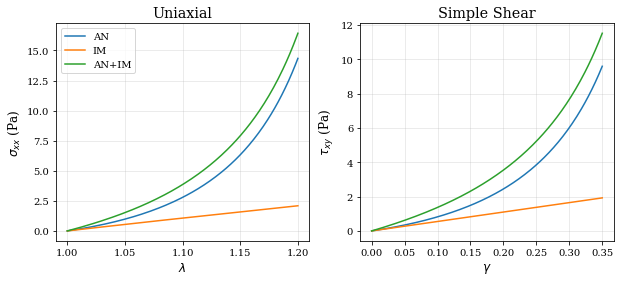

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(stretch_array, stress_AN_uni, label = 'AN')
axs[0].plot(stretch_array, stress_IM_uni, label = 'IM')
axs[0].plot(stretch_array, stress_uni, label = 'AN+IM')
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel('$\sigma_{xx}$ (Pa)')
axs[0].set_title('Uniaxial')
axs[0].legend()

axs[1].plot(shear_array, stress_AN_shear, label = 'AN')
axs[1].plot(shear_array, stress_IM_shear, label = 'IM')
axs[1].plot(shear_array, stress_shear, label = 'AN+IM')
axs[1].set_xlabel('$\gamma$')
axs[1].set_ylabel('$\\tau_{xy}$ (Pa)')
axs[1].set_title('Simple Shear')

for ax in axs:
    ax.grid(True, alpha=0.3)

In [21]:
print(np.all(stress_sum_uni - stress_uni <= abs(1e-3)))
print(np.all(stress_sum_shear - stress_shear <= abs(1e-14)))

True
True


In [22]:
stress_sum_uni[:20], stress_uni[:20], len(stress_sum_uni), len(stress_uni)

(array([8.88178420e-16, 2.59141820e-02, 5.11087418e-02, 7.69222793e-02,
        1.02908805e-01, 1.28628651e-01, 1.55415492e-01, 1.81494618e-01,
        2.08645460e-01, 2.35539171e-01, 2.63062803e-01, 2.89889257e-01,
        3.17351911e-01, 3.45010261e-01, 3.72865300e-01, 4.01362817e-01,
        4.28731541e-01, 4.57637451e-01, 4.86306709e-01, 5.15182367e-01]),
 array([8.88178420e-16, 2.56921374e-02, 5.11087418e-02, 7.69222793e-02,
        1.02908805e-01, 1.28850695e-01, 1.55415492e-01, 1.81716663e-01,
        2.08645460e-01, 2.35539171e-01, 2.62840758e-01, 2.89889257e-01,
        3.17351911e-01, 3.45010261e-01, 3.72865300e-01, 4.01140772e-01,
        4.28953585e-01, 4.57637451e-01, 4.86306709e-01, 5.15182367e-01]),
 200,
 200)